In [1]:
# 1. Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk K-means
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

# Library untuk Regresi Linear
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Library untuk Deployment (menyimpan model)
import pickle

In [2]:
# 2. Baca dataset
# Ganti nama file jika berbeda
df = pd.read_csv("dfTransjakarta.csv")

print("Jumlah baris dan kolom:", df.shape)
print("\nNama kolom dalam dataset:")
print(df.columns)
print("\n5 Data teratas:")
print(df.head())
print("\nInformasi dataset:")
print(df.info())

Jumlah baris dan kolom: (37900, 22)

Nama kolom dalam dataset:
Index(['transID', 'payCardID', 'payCardBank', 'payCardName', 'payCardSex',
       'payCardBirthDate', 'corridorID', 'corridorName', 'direction',
       'tapInStops', 'tapInStopsName', 'tapInStopsLat', 'tapInStopsLon',
       'stopStartSeq', 'tapInTime', 'tapOutStops', 'tapOutStopsName',
       'tapOutStopsLat', 'tapOutStopsLon', 'stopEndSeq', 'tapOutTime',
       'payAmount'],
      dtype='object')

5 Data teratas:
          transID         payCardID payCardBank      payCardName payCardSex  \
0  EIIW227B8L34VB   180062659848800      emoney   Bajragin Usada          M   
1  LGXO740D2N47GZ  4885331907664776         dki     Gandi Widodo          F   
2  DJWR385V2U57TO  4996225095064169         dki    Emong Wastuti          F   
3  JTUZ800U7C86EH      639099174703       flazz     Surya Wacana          F   
4  VMLO535V7F95NJ      570928206772       flazz  Embuh Mardhiyah          M   

   payCardBirthDate corridorID             

In [3]:
# 3. Data Cleaning

# Melihat jumlah nilai kosong
print("\nJumlah nilai kosong per kolom sebelum cleaning:")
print(df.isnull().sum())

# Cek data duplikat
duplicate_count = df.duplicated().sum()
print("\nJumlah data duplikat:", duplicate_count)
df = df.drop_duplicates()
print("Shape setelah hapus duplikat:", df.shape)

# Hapus baris dengan nilai kosong di kolom kunci untuk analisis rute
# (corridorName, tapInTime, tapOutTime, payAmount)
df.dropna(subset=['corridorName', 'tapInTime', 'tapOutTime', 'payAmount'], inplace=True)
print("\nShape setelah hapus baris NaN di kolom penting:", df.shape)


Jumlah nilai kosong per kolom sebelum cleaning:
transID                0
payCardID              0
payCardBank            0
payCardName            0
payCardSex             0
payCardBirthDate       0
corridorID          1257
corridorName        1930
direction              0
tapInStops          1213
tapInStopsName         0
tapInStopsLat          0
tapInStopsLon          0
stopStartSeq           0
tapInTime              0
tapOutStops         2289
tapOutStopsName     1344
tapOutStopsLat      1344
tapOutStopsLon      1344
stopEndSeq          1344
tapOutTime          1344
payAmount           1007
dtype: int64

Jumlah data duplikat: 0
Shape setelah hapus duplikat: (37900, 22)

Shape setelah hapus baris NaN di kolom penting: (33781, 22)


In [4]:
# 4. Preprocessing & Feature Engineering

# Konversi kolom waktu ke datetime dan hitung durasi (seperti di file Regresi Linear)
df['tapInTime'] = pd.to_datetime(df['tapInTime'], errors='coerce')
df['tapOutTime'] = pd.to_datetime(df['tapOutTime'], errors='coerce')
df['duration_min'] = (df['tapOutTime'] - df['tapInTime']).dt.total_seconds() / 60

# Buat data agregat per rute (dibutuhkan untuk kedua model)
# 'jumlah_transaksi' sebagai proxy untuk kepadatan rute
df_rute = df.groupby('corridorName').agg({
    'payAmount': 'mean',
    'duration_min': 'mean',
    'transID': 'count'
}).reset_index().rename(columns={'transID': 'jumlah_transaksi'})

# Hapus baris dengan nilai NaN yang mungkin muncul setelah perhitungan mean
df_rute.dropna(inplace=True)

print("\nDATA RINGKAS PER RUTE (df_rute) - 5 Data teratas:")
print(df_rute.head())
print("Jumlah rute unik yang valid:", df_rute.shape[0])


DATA RINGKAS PER RUTE (df_rute) - 5 Data teratas:
                             corridorName  payAmount  duration_min  \
0  Andara - Stasiun Universitas Pancasila        0.0     69.661062   
1                          BSD - Jelambar     3500.0     71.358974   
2                 BSD Serpong - Fatmawati    20000.0     76.585038   
3                       Batusari - Grogol     3500.0     71.743319   
4                   Bekasi Barat - Blok M    20000.0     72.872176   

   jumlah_transaksi  
0               226  
1               117  
2                88  
3               237  
4               121  
Jumlah rute unik yang valid: 211


/tmp/ipython-input-3846580130.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corridors.values, y=top_corridors.index, palette='viridis')


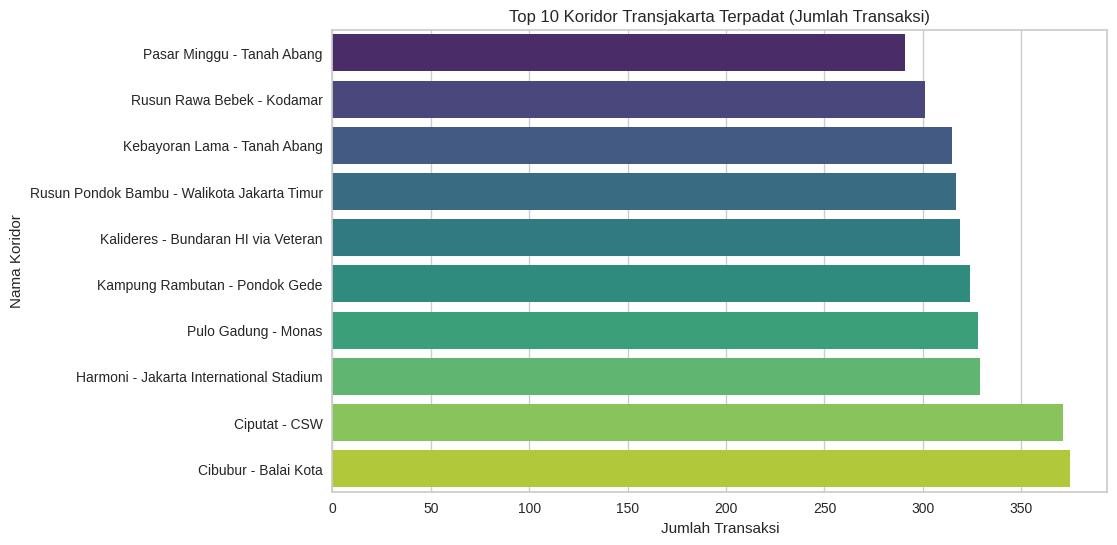

/tmp/ipython-input-3846580130.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_tapin_stops.values, y=top_tapin_stops.index, palette='plasma')


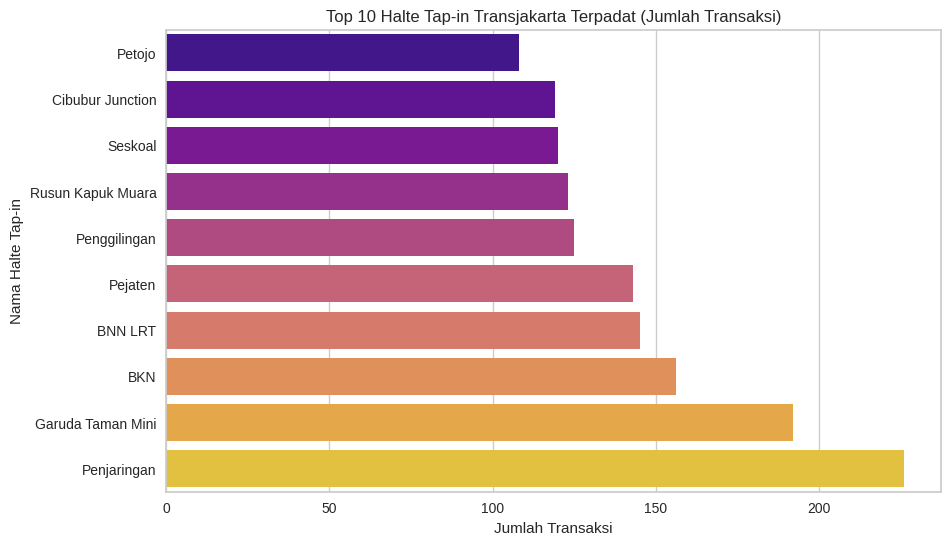

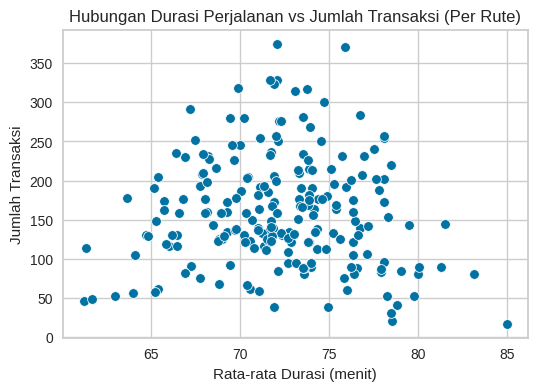

In [5]:
# 5. Visualisasi Data (Mempertahankan kode asli dari kedua file)

# --- Visualisasi dari Analisis K-means (Top Koridor & Tap-in) ---

# Top 10 Koridor Terpadat
top_corridors = df['corridorName'].value_counts().head(10).sort_values(ascending=True)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_corridors.values, y=top_corridors.index, palette='viridis')
plt.title("Top 10 Koridor Transjakarta Terpadat (Jumlah Transaksi)")
plt.xlabel("Jumlah Transaksi")
plt.ylabel("Nama Koridor")
plt.show()

# Top 10 Halte Tap-in Terpadat
top_tapin_stops = df['tapInStopsName'].value_counts().head(10).sort_values(ascending=True)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_tapin_stops.values, y=top_tapin_stops.index, palette='plasma')
plt.title("Top 10 Halte Tap-in Transjakarta Terpadat (Jumlah Transaksi)")
plt.xlabel("Jumlah Transaksi")
plt.ylabel("Nama Halte Tap-in")
plt.show()


# --- Visualisasi dari Analisis Regresi Linear (Durasi vs Kepadatan) ---

# Scatter plot: hubungan antara durasi dan kepadatan
plt.figure(figsize=(6, 4))
sns.scatterplot(x='duration_min', y='jumlah_transaksi', data=df_rute)
plt.title("Hubungan Durasi Perjalanan vs Jumlah Transaksi (Per Rute)")
plt.xlabel("Rata-rata Durasi (menit)")
plt.ylabel("Jumlah Transaksi")
plt.show()

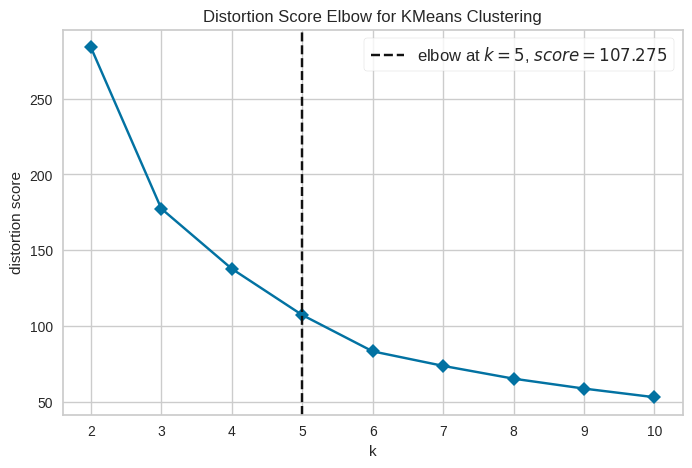

Silhouette Score: 0.336

5 data rute teratas setelah clustering:
                             corridorName  payAmount  duration_min  \
0  Andara - Stasiun Universitas Pancasila        0.0     69.661062   
1                          BSD - Jelambar     3500.0     71.358974   
2                 BSD Serpong - Fatmawati    20000.0     76.585038   
3                       Batusari - Grogol     3500.0     71.743319   
4                   Bekasi Barat - Blok M    20000.0     72.872176   

   jumlah_transaksi  cluster  
0               226        0  
1               117        1  
2                88        3  
3               237        0  
4               121        1  

✅ Model & scaler berhasil disimpan


In [12]:
# ================================
# 6. MODELING: K-MEANS CLUSTERING (IMPROVED)
# ================================

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import joblib

# Feature selection
X_cluster = df_rute[['duration_min', 'jumlah_transaksi']]

# Scaling (WAJIB)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# -------------------------------
# Elbow Method
# -------------------------------
plt.figure(figsize=(8, 5))
visualizer = KElbowVisualizer(
    KMeans(random_state=42, n_init=10),
    k=(2, 11),
    timings=False
)
visualizer.fit(X_scaled)
visualizer.ax.set_title("Elbow Method untuk K-Means")
visualizer.show()

# -------------------------------
# Training Model Final
# -------------------------------
optimal_k = 4   # sesuaikan hasil elbow
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_rute['cluster'] = kmeans.fit_predict(X_scaled)

# -------------------------------
# Evaluasi Clustering
# -------------------------------
sil_score = silhouette_score(X_scaled, df_rute['cluster'])
print(f"Silhouette Score: {sil_score:.3f}")

# -------------------------------
# Simpan Model untuk Deploy
# -------------------------------
joblib.dump(kmeans, "model_kmeans_transjakarta.pkl")
joblib.dump(scaler, "scaler_kmeans.pkl")

print("\n5 data rute teratas setelah clustering:")
print(df_rute.head())
print("\n✅ Model & scaler berhasil disimpan")



Ringkasan Statistik Cluster:
   cluster  jumlah_transaksi  duration_min    payAmount
0        0        250.944444     72.971854  2490.740741
1        1        138.743590     72.551652  2384.615385
2        2        135.913043     66.533839  2717.391304
3        3         95.636364     78.191035  3484.848485


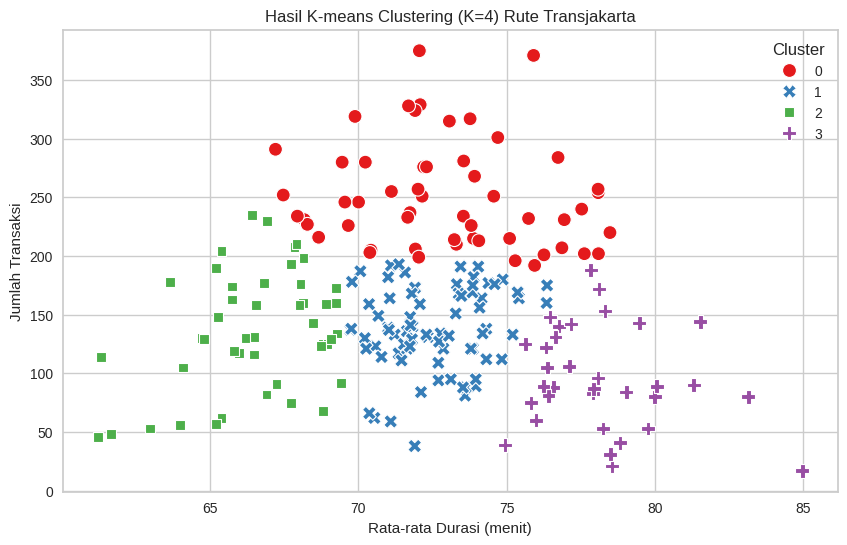

In [13]:
# 7. Evaluasi K-means & Visualisasi Cluster

# Melihat ringkasan statistik per cluster
cluster_summary = df_rute.groupby('cluster')[['jumlah_transaksi', 'duration_min', 'payAmount']].mean().reset_index()
print("\nRingkasan Statistik Cluster:")
print(cluster_summary)

# Visualisasi Hasil Clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='duration_min',
    y='jumlah_transaksi',
    data=df_rute,
    hue='cluster',
    palette='Set1',
    style='cluster',
    s=100
)
plt.title(f"Hasil K-means Clustering (K={optimal_k}) Rute Transjakarta")
plt.xlabel("Rata-rata Durasi (menit)")
plt.ylabel("Jumlah Transaksi")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Beri label pada Cluster: (misalnya)
# Cluster 0: Rute Padat, Durasi Tinggi
# Cluster 1: Rute Sedang, Durasi Sedang
# Cluster 2: Rute Sepi, Durasi Rendah
# Cluster 3: Rute Padat, Durasi Pendek

Ukuran data latih  : (147, 2)
Ukuran data uji    : (64, 2)

Model Regresi Linear berhasil dilatih
RMSE : 64.054
R²   : -0.054

Koefisien Model:
          Fitur  Koefisien
0  duration_min  -3.783696
1     payAmount   0.388514
Intercept: 155.545


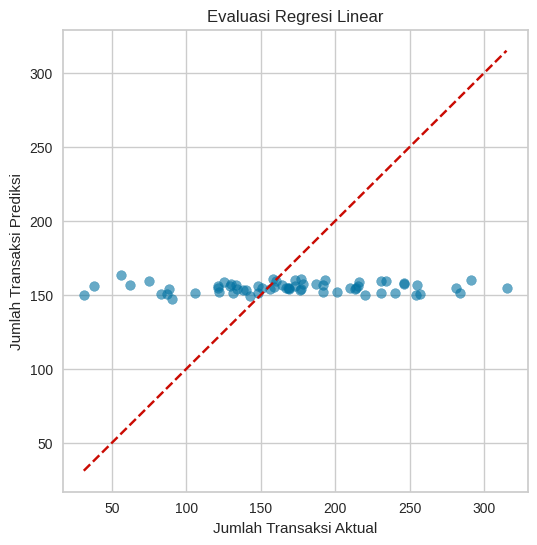


✅ Model regresi & scaler berhasil disimpan


In [15]:
# ================================
# 8. MODELING: REGRESI LINEAR
# ================================

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# -------------------------------
# Feature & Target
# -------------------------------
X_reg = df_rute[['duration_min', 'payAmount']]
y_reg = df_rute['jumlah_transaksi']

# -------------------------------
# Scaling (PENTING)
# -------------------------------
scaler_reg = StandardScaler()
X_scaled = scaler_reg.fit_transform(X_reg)

# -------------------------------
# Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_reg, test_size=0.3, random_state=42
)

print(f"Ukuran data latih  : {X_train.shape}")
print(f"Ukuran data uji    : {X_test.shape}")

# -------------------------------
# Training Model
# -------------------------------
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

print("\nModel Regresi Linear berhasil dilatih")

# -------------------------------
# Evaluasi Model
# -------------------------------
y_pred = model_lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")

# -------------------------------
# Interpretasi Model
# -------------------------------
coef_df = pd.DataFrame({
    "Fitur": X_reg.columns,
    "Koefisien": model_lr.coef_
})

print("\nKoefisien Model:")
print(coef_df)
print(f"Intercept: {model_lr.intercept_:.3f}")

# -------------------------------
# Visualisasi Aktual vs Prediksi
# -------------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Jumlah Transaksi Aktual")
plt.ylabel("Jumlah Transaksi Prediksi")
plt.title("Evaluasi Regresi Linear")
plt.show()

# -------------------------------
# Simpan Model untuk Deploy
# -------------------------------
joblib.dump(model_lr, "model_regresi_transjakarta.pkl")
joblib.dump(scaler_reg, "scaler_regresi.pkl")

print("\n✅ Model regresi & scaler berhasil disimpan")


In [20]:
# =================================================
# 8. SIMPAN METRIK MODEL TERBAIK
# =================================================

model_metrics = {
    "regresi": {
        "RMSE": rmse,
        "R2": r2
    },
    "kmeans": {
        "silhouette": sil_score,
        "n_cluster": optimal_k
    }
}

joblib.dump(model_metrics, "model_metrics.pkl")


['model_metrics.pkl']

In [21]:
# =================================================
# 9. DEPLOY MANUAL - LOAD MODEL & METRIK
# =================================================

kmeans_model = joblib.load("model_kmeans_transjakarta.pkl")
scaler_kmeans = joblib.load("scaler_kmeans.pkl")

reg_model = joblib.load("model_regresi_transjakarta.pkl")
scaler_reg = joblib.load("scaler_regresi.pkl")

metrics = joblib.load("model_metrics.pkl")

print("MODEL TERBAIK YANG DIGUNAKAN")
print("-----------------------------")
print(f"RMSE Regresi      : {metrics['regresi']['RMSE']:.3f}")
print(f"R² Regresi        : {metrics['regresi']['R2']:.3f}")
print(f"Silhouette KMeans : {metrics['kmeans']['silhouette']:.3f}")
print(f"Jumlah Cluster    : {metrics['kmeans']['n_cluster']}")


MODEL TERBAIK YANG DIGUNAKAN
-----------------------------
RMSE Regresi      : 64.054
R² Regresi        : -0.054
Silhouette KMeans : 0.336
Jumlah Cluster    : 4


In [22]:
# =================================================
# 10. DEPLOY MANUAL - FUNGSI PREDIKSI
# =================================================

def prediksi_rute(duration_min, payAmount):
    X_reg = scaler_reg.transform([[duration_min, payAmount]])
    pred_transaksi = reg_model.predict(X_reg)[0]

    X_km = scaler_kmeans.transform([[duration_min, pred_transaksi]])
    cluster = kmeans_model.predict(X_km)[0]

    return pred_transaksi, cluster


In [23]:
# =================================================
# 11. UJI DEPLOY MANUAL
# =================================================

duration = 45
pay = 3500

pred_transaksi, cluster = prediksi_rute(duration, pay)

print(f"Durasi          : {duration} menit")
print(f"Pay Amount      : {pay}")
print(f"Pred Transaksi  : {int(pred_transaksi)}")
print(f"Cluster         : {cluster}")

if cluster == 0:
    print("Kategori: Rute sepi")
elif cluster == 1:
    print("Kategori: Rute sedang")
else:
    print("Kategori: Rute padat")


Durasi          : 45 menit
Pay Amount      : 3500
Pred Transaksi  : 179
Cluster         : 2
Kategori: Rute padat


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
